In [127]:
import pandas as pd
import math
import os
import numpy as np
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from matplotlib.patches import Circle
import heapq 
import pandas as pd
import datetime as dt
from datetime import timedelta
import seaborn as sns
os.sys.path.append('../')
from center_constants import *
from geometry_utils import *

In [137]:
def Convert(string): 
    """"String to list conversion"""
    li = list(string.split(", ")) 
    for i in range(len(li)):
        li[i] = float(li[i])
    return li

def get_name(file_name):
    '''Get the plant name associated with the given file name'''
    i = 0
    while file_name[i].isalpha() or file_name[i] == '_':
        i += 1
    return file_name[:i]

def get_plant_radii(path):
    '''retrieve and convert plant radii data into usable grouped format'''
    file_list = os.listdir(path)
    list.sort(file_list)
    out = {}
    for file in file_list:
        if file == '.DS_Store':
            continue
        f = open(path + file, "r")
        item = f.read()
        item = item[1:len(item)-1]
        l = Convert(item)
        plant_type = get_name(file)
        if plant_type in out:
            out[plant_type].append(l)
        else: 
            out[plant_type] = [l]
    return out
    
def max_sprouting_time(plant_vals):
    '''Given each of the plants growth curves, find the max time it takes for the plant to sprout'''
    i = 0
    for radii_on_day in zip(plant_vals.iloc):
        if max([np.array(tup)[0] for tup in radii_on_day]) > .1:
            return i - 1
        i += 1
    
def plot_plant_vals(vals, name):
    '''Plot the values given in a scatter plot'''
    print(name)
    new_vals = []
    sprouting_time = max_sprouting_time(vals.T) 
    print(sprouting_time)
    for row in vals.iloc:
        new_row = []
        for i, val in enumerate(row[sprouting_time:]):
            if val - row[max(0, i-1)] < -4 or (i > 20 and val == 0):
                break
            new_row.append(val)
        plt.scatter([i for i in range(1, len(new_row)+1)], new_row)
        new_vals.append(new_row)
    plt.xlabel("Days since sprouting")
    plt.ylabel("Radius (cm)")
    plt.title(name.capitalize())
    plt.show()
    return new_vals

def get_model(key):
    '''Generate model based on the key given'''
    values = pd.DataFrame(plant_radii[key]).T
    points = {}
    for i in range(values.shape[0]):
        for val in values.iloc[i]:
            if math.isnan(val):
                continue
            else:
                if i in points:
                    points[i].append(val)
                else:
                    points[i] = [val]
    values = pd.DataFrame({k: [max(points[k])] for k in points.keys()}).T
    X = np.array([i for i in range(values.shape[0])]).reshape(-1, 1)
    y = values
    lin_reg = LinearRegression().fit(X, y)

    encoded = y.astype(int)
    logistic_reg = LogisticRegression().fit(X, encoded)
    gbm = GradientBoostingRegressor(loss="quantile", alpha=.6)
    gbm.fit(X, y)
    values["predicted_lin"] = lin_reg.predict(np.array([i for i in range(values.shape[0])]).reshape(values.shape[0], -1))
    values["predicted_log"] = logistic_reg.predict(np.array([i for i in range(values.shape[0])]).reshape(values.shape[0], -1)) 
    # values["predicted_gbm"] = gbm.predict(np.array([i for i in range(values.shape[0])]).reshape(values.shape[0], -1)) 
    print(key)
    plt.plot(values)
    plt.xlabel("Days since sprouting")
    plt.ylabel("Radius (cm)")
    plt.title(key.capitalize())
    plt.legend(('Actual', 'Linear', 'Logistic'))
    plt.show()
    return lin_reg, logistic_reg

In [138]:
plant_radii = get_plant_radii("./batch_both/")
for k in plant_radii.keys():
    plant_radii[k] = pd.DataFrame(plant_radii[k])

arugula
11


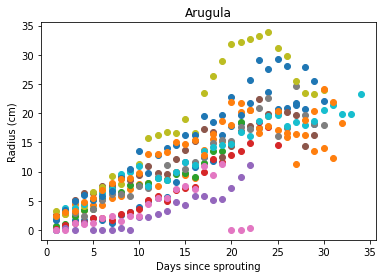

borage
7


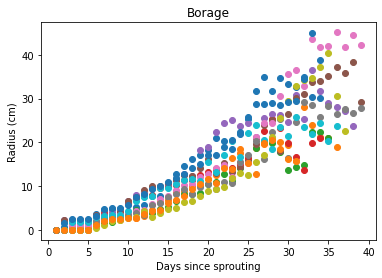

cilantro
12


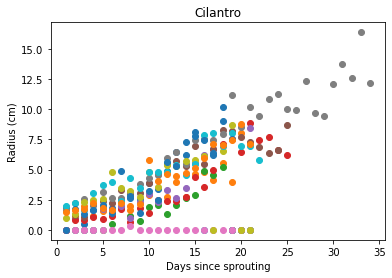

green_lettuce
11


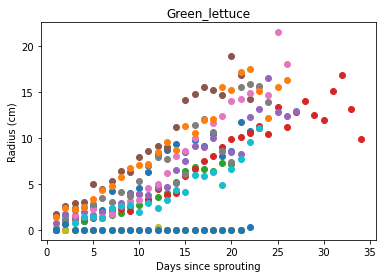

kale
13


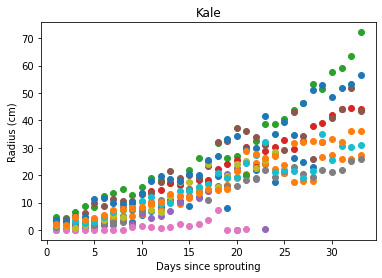

radicchio
11


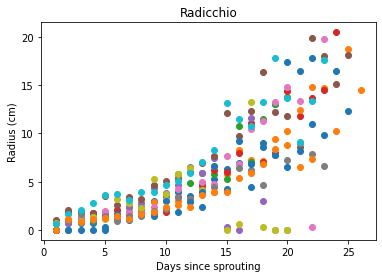

red_lettuce
15


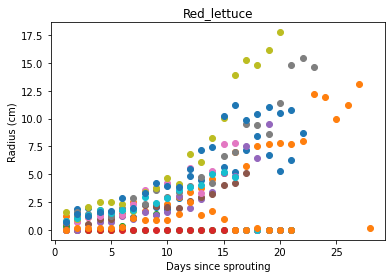

sorrel
11


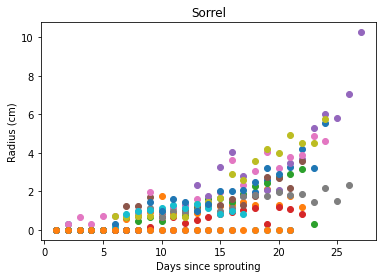

swiss_chard
7


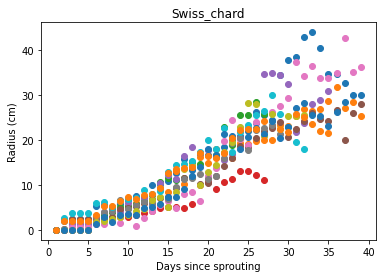

turnip
7


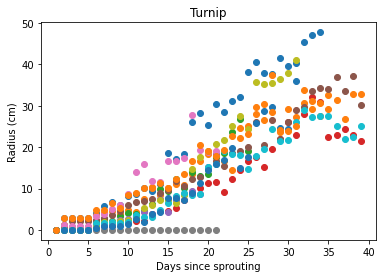

In [139]:
for key in plant_radii.keys():
    plant_radii[key] = plot_plant_vals(plant_radii[key], key)

arugula


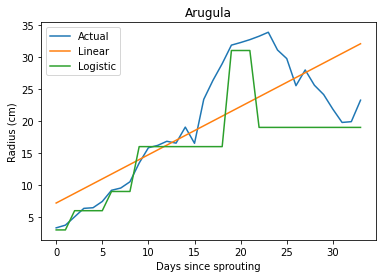

borage


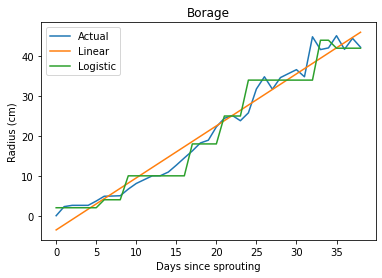

cilantro


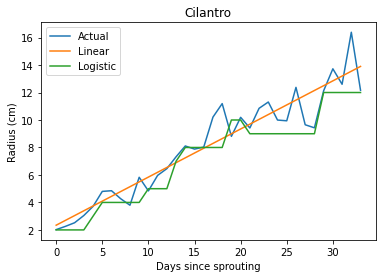

green_lettuce


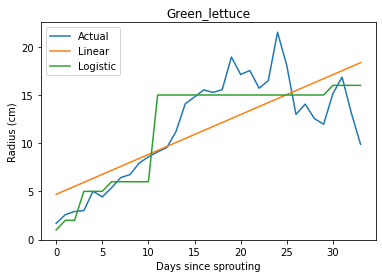

kale


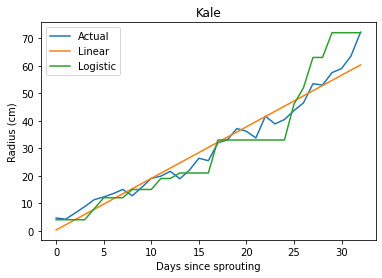

radicchio


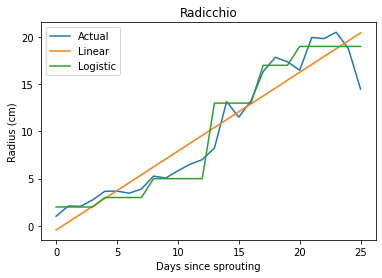

red_lettuce


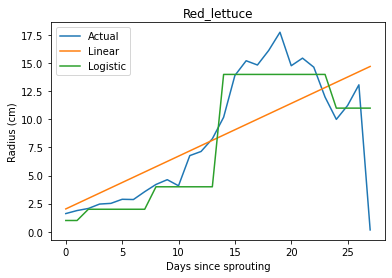

sorrel


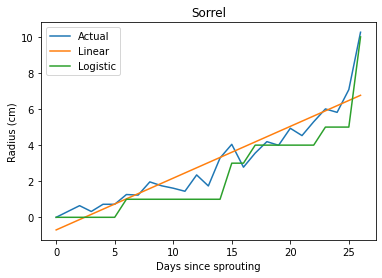

swiss_chard


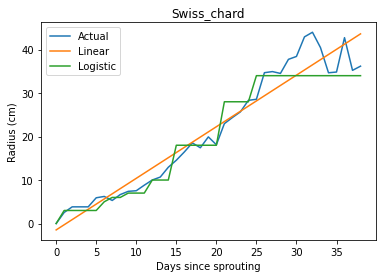

turnip


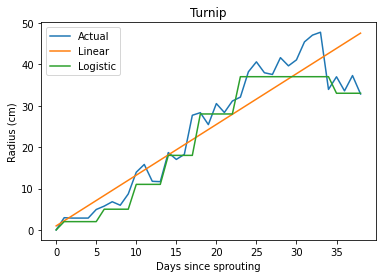

In [140]:
models = {}
for key in plant_radii.keys():
    models[key] = get_model(key)
pkl.dump(models, open("./models/lin_log_models.p", "wb"))

In [143]:
m = pkl.load(open( "./models/lin_log_models.p", "rb" ))
print(m)
m["borage"].predict(np.array([7]).reshape(1, -1))

{'arugula': LinearRegression(), 'borage': LinearRegression(), 'cilantro': LinearRegression(), 'green_lettuce': LinearRegression(), 'kale': LinearRegression(), 'radicchio': LinearRegression(), 'red_lettuce': LinearRegression(), 'sorrel': LinearRegression(), 'swiss_chard': LinearRegression(), 'turnip': LinearRegression()}


array([[5.56865003]])